In [1]:
import numpy as np 
from numpy import zeros
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
import matplotlib.pyplot as plt

2024-06-21 20:36:00.486742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 20:36:00.624709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/rolling/opt/rviz_ogre_vendor/lib:/opt/ros/rolling/lib/x86_64-linux-gnu:/opt/ros/rolling/lib
2024-06-21 20:36:00.624731: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-21 20:36:00.654931: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for 

In [2]:
(trainX, trainy), (testX, testy) = load_data()

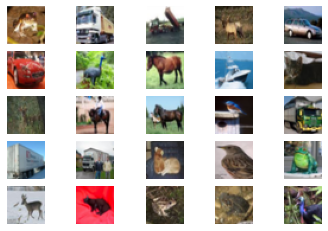

In [3]:
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(trainX[i])
plt.show()

In [4]:
trainX[1].shape

(32, 32, 3)

In [5]:
def define_discriminator(in_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='cross_entropy', optimizer='adam', metrics=['accuracy'])
    return model



In [6]:
test_discr = define_discriminator()
test_discr.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8

2024-06-21 20:36:04.244651: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/rolling/opt/rviz_ogre_vendor/lib:/opt/ros/rolling/lib/x86_64-linux-gnu:/opt/ros/rolling/lib
2024-06-21 20:36:04.244688: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-21 20:36:04.244713: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mhmud): /proc/driver/nvidia/version does not exist
2024-06-21 20:36:04.245021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128*8*8
    model.add(Dense(n_nodes, input_dim= latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(3, (8, 8), activation='tanh', padding='same')) #32x32x3
    return model
    
              

In [8]:
test_gen = define_generator(10)
test_gen.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              90112     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

In [9]:
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    
    

In [10]:
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    X = trainX.astype('float32')
    X = X/255.0
    return X

In [11]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

In [12]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim*n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [13]:
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_fake_samples(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y
    

In [14]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
    bat_per_epo = int(dataset.shape[0]/128)
    half_batch = int(n_batch/2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss_real,_ = d_model.train_on_batch(X_real, y_real)
            
            
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            
            print('epoch > %d ,Batch %d/%d, d1=%.3f, d2=%.2f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
            
        

In [15]:
latent_dim = 10
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=2)

ValueError: in user code:

    File "/home/mhmud/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/mhmud/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mhmud/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/mhmud/.local/lib/python3.10/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/mhmud/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/home/mhmud/.local/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 240, in __call__
        self.build(y_pred)
    File "/home/mhmud/.local/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 182, in build
        self._losses = tf.nest.map_structure(
    File "/home/mhmud/.local/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 353, in _get_loss_object
        loss = losses_mod.get(loss)
    File "/home/mhmud/.local/lib/python3.10/site-packages/keras/losses.py", line 2649, in get
        return deserialize(identifier)
    File "/home/mhmud/.local/lib/python3.10/site-packages/keras/losses.py", line 2603, in deserialize
        return deserialize_keras_object(
    File "/home/mhmud/.local/lib/python3.10/site-packages/keras/utils/generic_utils.py", line 769, in deserialize_keras_object
        raise ValueError(

    ValueError: Unknown loss function: cross_entropy. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
